In [1]:
import os
import pandas as pd

In [ ]:

# Paths
drum_dir = r"D:\pyspace\Djembe\2025\mocap_formats\data\drum_onsets"
start_times_path = r"D:\pyspace\Djembe\2025\mocap_formats\data\start_times_part12.csv"

# Load start times and keep only recordings with a defined Part 2 start
df_times = pd.read_csv(start_times_path)
df_p2 = df_times.dropna(subset=['start_time_p2_seconds'])

for _, row in df_p2.iterrows():
    recording = row['recording']               # e.g. "BKO_E1_D1_01_Suku_P2"
    threshold = row['start_time_p2_seconds']   # float seconds

    # Derive the CSV filename by stripping the "_P2" suffix
    base_name = recording.rsplit('_', 1)[0]    # e.g. "BKO_E1_D1_01_Suku"
    csv_path = os.path.join(drum_dir, f"{base_name}.csv")

    if not os.path.isfile(csv_path):
        print(f"Warning: file not found: {csv_path}")
        continue

    # Read the CSV
    df = pd.read_csv(csv_path)
    print(f"\nProcessing {base_name}")
    print(f"Threshold: {threshold}")
    print(f"Original number of rows: {len(df)}")
    
    # Print column lengths before trimming
    print("\nColumn lengths before trimming:")
    for col in ['Dun', 'J1', 'J2']:
        print(f"{col}: {df[col].count()} non-NaN values")
    
    # Trim each column independently
    df['Dun'] = df['Dun'].where(df['Dun'] <= threshold)
    df['J1'] = df['J1'].where(df['J1'] <= threshold)
    df['J2'] = df['J2'].where(df['J2'] <= threshold)
    
    # Print column lengths after trimming
    print("\nColumn lengths after trimming:")
    for col in ['Dun', 'J1', 'J2']:
        print(f"{col}: {df[col].count()} non-NaN values")
    
    # Save the modified dataframe
    df.to_csv(csv_path, index=False)
    print(f"Trimmed and saved: {csv_path}")

In [11]:
import os
import re
import csv
import math

parts_dir = r"D:\pyspace\Djembe\2025\mocap_formats\data\parts"
output_csv = r"D:\pyspace\Djembe\2025\mocap_formats\data\start_times_part12_seconds.csv"

def timestamp_to_seconds(ts):
    """
    Convert a timestamp 'HH:MM:SS,mmm' to total seconds (float).
    """
    hh, mm, ss_ms = ts.split(':')
    ss, ms = ss_ms.split(',')
    return int(hh) * 3600 + int(mm) * 60 + int(ss) + int(ms) / 1000.0

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['recording', 'start_time_p1_seconds', 'start_time_p2_seconds'])

    # include both *_P1.txt and *_P2.txt files
    for fname in os.listdir(parts_dir):
        if not fname.endswith(('_P1.txt', '_P2.txt')):
            continue

        recording_name = fname.rsplit('.txt', 1)[0]
        full_path = os.path.join(parts_dir, fname)

        p1_ts = None
        p2_ts = None

        with open(full_path, 'r', encoding='utf-8') as f:
            for line in f:
                if p1_ts is None:
                    m1 = re.match(r'^\s*([\d]{2}:[\d]{2}:[\d]{2},\d{3})\s+"1"', line)
                    if m1:
                        p1_ts = m1.group(1)
                if p2_ts is None:
                    m2 = re.match(r'^\s*([\d]{2}:[\d]{2}:[\d]{2},\d{3})\s+"2"', line)
                    if m2:
                        p2_ts = m2.group(1)
                if p1_ts and p2_ts:
                    break

        # convert to seconds, use NaN if missing
        secs1 = timestamp_to_seconds(p1_ts) if p1_ts else math.nan
        secs2 = timestamp_to_seconds(p2_ts) if p2_ts else math.nan

        writer.writerow([recording_name, secs1, secs2])


### Build Tempo Data

In [ ]:
import os
import pandas as pd

# Directory containing the original CSV files
cycles_dir = r"D:\pyspace\Djembe\2025\mocap_formats\data\virtual_cycles"
save_dir= r"D:\pyspace\Djembe\2025\mocap_formats\data"

# Directory where the new CSVs (with cycle_onset, IOI, and tempo columns) will be saved
output_dir = os.path.join(save_dir, "tempo")
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(cycles_dir):
    if not filename.lower().endswith(".csv"):
        continue

    input_path = os.path.join(cycles_dir, filename)
    df = pd.read_csv(input_path)

    # Ensure "Virtual Onset" column exists
    if "Virtual Onset" not in df.columns:
        print(f"Skipping {filename}: no 'Virtual Onset' column.")
        continue

    # Create a new dataframe with the required columns
    df_new = pd.DataFrame()
    df_new["cycle_onset"] = df["Virtual Onset"]

    # Compute IOI (cycle duration) = time from this onset to the next onset
    df_new["ioi"] = df_new["cycle_onset"].shift(-1) - df_new["cycle_onset"]

    # Compute tempo in BPM for each cycle: BPM = 4 beats * (60 seconds / cycle duration) = 240 / IOI
    df_new["tempo"] = 240.0 / df_new["ioi"]

    # Optional: if you prefer to fill the last row’s tempo with the previous value instead of NaN:
    # df["tempo"].fillna(method="ffill", inplace=True)

    # Save to the new directory, preserving the original filename
    output_path = os.path.join(output_dir, filename)
    df_new.to_csv(output_path, index=False)

    print(f"Processed {filename} → saved to {output_path}")


### Prepare data for clustering

In [83]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

with open('data/selected_piece_list.pkl', 'rb') as f:
    piece_list = pickle.load(f)

m_idx = 0
mode = ["group", "individual", "audience"]
dance_mode = mode[m_idx]

cluster_data = {
    "file_name": [],    # string
    
    "dmode_name": [],   # string
    "dmode_seg_idx": [], # int
    "dmode_start": [],  # float
    "dmode_end": [],    # float
    
    "cycle_idx": [],    # int
    "cycle_start": [],  # float
    "cycle_end": [],    # float
    
    "location": [],     # string
    "ensemble": [],     # string
    "day": [],          # string
    "rec_no": [], # string
    "piece": [],        # string
    
    "L_traj": [],      # numpy array
    "R_traj": [],       # numpy array
    "LR_traj": []       # numpy array
}



for file_name in piece_list:

    
    # file_name = piece_list[0]  # BKO_E1_D1_01_Suku
    location = file_name.split("_")[0]      # BKO
    ensemble = file_name.split("_")[1]      # E1
    day = file_name.split("_")[2]           # D1
    recording_no = file_name.split("_")[3]  # 01
    piece = file_name.split("_")[4]         # Suku


    base_path_cycles = "data/virtual_cycles"
    onsets_csv_path = f"data/drum_onsets/{file_name}.csv"
    base_path_logs= "data/logs_v4_0.007_foot_jun3"           # "data/logs_v2_may",   # "data/logs_v3_0.2_lower_jun3",    # "data/logs_v4_0.007_foot_jun3", 
    dance_mode_path = f"data/dance_modes_ts/{file_name}_{dance_mode}.pkl"


    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")

    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Left_zpos = pd.read_csv(left_zpos_csv)["zpos"].values
    Right_zpos = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Left_zpos)
    times = np.arange(n_frames) / 240

    # load cycles
    cyc_df = pd.read_csv(cycles_csv)

    # load dance mode time segments
    if os.path.exists(dance_mode_path):
        with open(dance_mode_path, "rb") as f:
            dmode_ts = pickle.load(f)

    print(location, ensemble, day, recording_no, piece)
    print(dance_mode)
    print(dmode_ts) 
    
    
    for dmode_idx, dmode in enumerate(dmode_ts):
        dmode_start, dmode_end = dmode
        print("dmode_seg_no:", dmode_idx+1)
        print("dmode_segment:", dmode_start, dmode_end)

        onsets = cyc_df["Virtual Onset"].values     # in seconds

        # Filter onsets to get only those within the dance mode time segment
        mode_mask = (onsets >= dmode_start) & (onsets <= dmode_end)
        mode_onsets = onsets[mode_mask]

        # Create list of tuples with start and end times of cycles within the dance mode segment
        cycle_times = [(round(mode_onsets[i], 3), round(mode_onsets[i+1], 3)) for i in range(len(mode_onsets)-1)]
        # print("cycle_times:", cycle_times)

        for c_idx, (c_start, c_end) in enumerate(cycle_times):
            # print("cycle:", c_idx+1, c_start, c_end)
        
            win_mask = (times >= c_start) & (times <= c_end)
            t_win = times[win_mask]
            Left_zpos_win = Left_zpos[win_mask]
            Right_zpos_win = Right_zpos[win_mask]
            
            left_right_zpos = np.concatenate((Left_zpos_win, Right_zpos_win))
            
            # print(c_idx+1,(Left_zpos_win).shape, (Right_zpos_win).shape, left_right_zpos.shape)
            
            cluster_data["file_name"].append(file_name)
            
            cluster_data["dmode_name"].append(dance_mode)
            cluster_data["dmode_seg_idx"].append(dmode_idx+1)
            cluster_data["dmode_start"].append(dmode_start)
            cluster_data["dmode_end"].append(dmode_end)
            
            cluster_data["cycle_idx"].append(c_idx+1)
            cluster_data["cycle_start"].append(c_start)
            cluster_data["cycle_end"].append(c_end)

            cluster_data["location"].append(location)
            cluster_data["ensemble"].append(ensemble)
            cluster_data["day"].append(day)
            cluster_data["rec_no"].append(recording_no)
            cluster_data["piece"].append(piece)
            
            cluster_data["L_traj"].append(Left_zpos_win)
            cluster_data["R_traj"].append(Right_zpos_win)
            cluster_data["LR_traj"].append(left_right_zpos)
        
 
with open(f"cluster_data_{dance_mode}.pkl", "wb") as f:
    pickle.dump(cluster_data, f)

from scipy.io import savemat
savemat(f"cluster_data_{dance_mode}.mat", cluster_data)


BKO E1 D1 01 Suku
group
[(35.52, 71.44)]
dmode_seg_no: 1
dmode_segment: 35.52 71.44
BKO E1 D1 02 Maraka
group
[(23.16, 65.2)]
dmode_seg_no: 1
dmode_segment: 23.16 65.2
BKO E1 D1 03 Wasulunka
group
[(32.06, 75.52)]
dmode_seg_no: 1
dmode_segment: 32.06 75.52
BKO E1 D1 06 Manjanin
group
[(53.94, 71.18)]
dmode_seg_no: 1
dmode_segment: 53.94 71.18
BKO E1 D1 07 Suku
group
[(53.94, 71.18)]
dmode_seg_no: 1
dmode_segment: 53.94 71.18
BKO E1 D1 08 Suku
group
[(53.94, 71.18)]
dmode_seg_no: 1
dmode_segment: 53.94 71.18
BKO E1 D2 03 Suku
group
[(76.78, 109.82)]
dmode_seg_no: 1
dmode_segment: 76.78 109.82
BKO E1 D2 04 Maraka
group
[(31.08, 69.5)]
dmode_seg_no: 1
dmode_segment: 31.08 69.5
BKO E1 D2 05 Wasulunka
group
[(62.12, 75.02)]
dmode_seg_no: 1
dmode_segment: 62.12 75.02
BKO E1 D5 01 Maraka
group
[(62.12, 75.02)]
dmode_seg_no: 1
dmode_segment: 62.12 75.02
BKO E1 D5 04 Suku
group
[(62.12, 75.02)]
dmode_seg_no: 1
dmode_segment: 62.12 75.02
BKO E2 D3 01 Maraka
group
[(12.44, 49.26)]
dmode_seg_no: 1

In [70]:
for dmode_idx, dmode in enumerate(dmode_ts):
    dmode_start, dmode_end = dmode
    print("dmode_seg_no:", dmode_idx+1)
    print("dmode_segment:", dmode_start, dmode_end)

    onsets = cyc_df["Virtual Onset"].values     # in seconds

    # Filter onsets to get only those within the dance mode time segment
    mode_mask = (onsets >= dmode_start) & (onsets <= dmode_end)
    mode_onsets = onsets[mode_mask]

    # Create list of tuples with start and end times of cycles within the dance mode segment
    cycle_times = [(round(mode_onsets[i], 3), round(mode_onsets[i+1], 3)) for i in range(len(mode_onsets)-1)]
    # print("cycle_times:", cycle_times)

    for c_idx, (c_start, c_end) in enumerate(cycle_times):
        # print("cycle:", c_idx+1, c_start, c_end)
    
        win_mask = (times >= c_start) & (times <= c_end)
        t_win = times[win_mask]
        Left_zpos_win = Left_zpos[win_mask]
        Right_zpos_win = Right_zpos[win_mask]
        
        left_right_zpos = np.concatenate((Left_zpos_win, Right_zpos_win))
        
        print(c_idx+1,(Left_zpos_win).shape, (Right_zpos_win).shape, left_right_zpos.shape)
    
    break

dmode_seg_no: 1
dmode_segment: 141.52 161.38
cycle_times: [(141.69, 142.955), (142.955, 144.195), (144.195, 145.38), (145.38, 146.582), (146.582, 147.771), (147.771, 148.96), (148.96, 150.154), (150.154, 151.383), (151.383, 152.612), (152.612, 153.834), (153.834, 155.058), (155.058, 156.285), (156.285, 157.503), (157.503, 158.733), (158.733, 159.979), (159.979, 161.187)]
1 (304,) (304,) (608,)
2 (297,) (297,) (594,)
3 (285,) (285,) (570,)
4 (288,) (288,) (576,)
5 (286,) (286,) (572,)
6 (285,) (285,) (570,)
7 (286,) (286,) (572,)
8 (295,) (295,) (590,)
9 (295,) (295,) (590,)
10 (294,) (294,) (588,)
11 (293,) (293,) (586,)
12 (295,) (295,) (590,)
13 (292,) (292,) (584,)
14 (295,) (295,) (590,)
15 (299,) (299,) (598,)
16 (290,) (290,) (580,)


In [66]:
a = np.array([1,2,3,5])
b = np.array([4,6,7,8])

c = np.concatenate((a,b))

print(a.shape, b.shape, c.shape)


(4,) (4,) (8,)


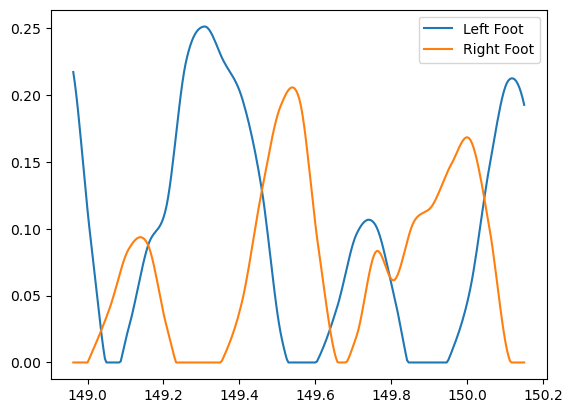

In [50]:




# plot
plt.plot(t_win, Left_zpos_win, label='Left Foot')
plt.plot(t_win, Right_zpos_win, label='Right Foot')
plt.legend()
plt.show()